In [2]:
import os, sys
sys.path.append('../')
os.chdir('../')

In [3]:
import torch
import random
import numpy as np
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import BertForSequenceClassification
from src.utils import set_seed

e:\code\project-list\bert-hfacs\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [6]:
# Fungsi untuk memuat model yang sudah dilatih
def load_model(model, load_model_name="model", load_model_dir="E:/code/project-list/bert-hfacs/models/model_trained/"):
    # Pastikan direktori ada, jika tidak buat
    os.makedirs(load_model_dir, exist_ok=True)

    # Gabungkan nama model dengan ekstensi .pth
    load_model_name_with_extension = load_model_name + ".pth"

    # Gabungkan direktori dan nama file model
    load_path = os.path.join(load_model_dir, load_model_name_with_extension)

    # Memuat model state_dict
    model.load_state_dict(
        torch.load(
            load_path,
            map_location=torch.device('cpu'),  # Ganti ke 'cuda' jika menggunakan GPU
        )
    )
    print("Model Weight Loaded")
    return model


In [8]:
model_path = "E:/code/project-list/bert-hfacs/models/indobert_base"

In [9]:
# 1. Buat config dengan arsitektur paling sederhana
config = BertConfig.from_pretrained(
    model_path,
    hidden_size=768,  # Ukuran hidden layer, harus sama denan intermediate size
    num_attention_heads=12,  # 1 attention head
    num_hidden_layers=12,
    num_labels= 2
)

In [10]:
tokenizer = BertTokenizer.from_pretrained(model_path)

In [11]:
model = BertForSequenceClassification.from_pretrained(
    model_path,
    config=config,
    attn_implementation="eager"
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at E:/code/project-list/bert-hfacs/models/indobert_base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
model = model.cuda()

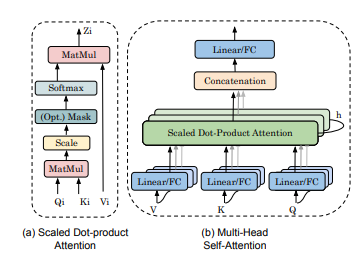

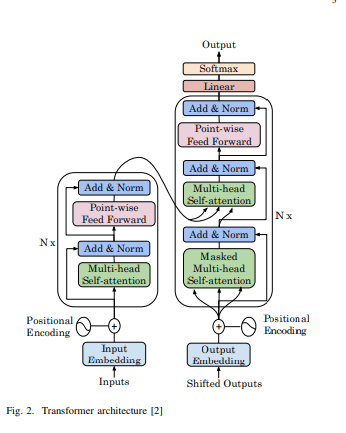

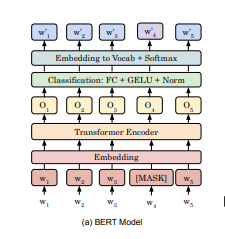

In [13]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [14]:
# 2. Contoh input teks
input_text = "supir mobil kantuk"

In [24]:
from src.dataset import HfacsDataset

w2i, i2w = HfacsDataset.LABEL2INDEX, HfacsDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'UA': 0, 'PRE': 1}
{0: 'UA', 1: 'PRE'}


In [18]:
subwords = tokenizer.encode(input_text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)
print(subwords)

tensor([[    2, 14884,   895, 27395,     3]], device='cuda:0')


In [20]:
logits = model(subwords)[0]
print(logits)

tensor([[-0.0913,  0.1649]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [23]:
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()
print(label)

1


In [32]:
coba = F.softmax(logits)

C:\Users\USER\AppData\Local\Temp\ipykernel_15192\3087947907.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  coba = F.softmax(logits)


In [29]:
print(f'Text: {input_text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: supir mobil kantuk | Label : PRE (56.371%)
